In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geofeather
import datashader as ds
from datashader import transfer_functions as tf
from colorcet import fire
import holoviews as hv
from holoviews import opts
from holoviews.element.tiles import EsriImagery, CartoDark, OSM, StamenTerrain
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

ModuleNotFoundError: No module named 'geofeather'

* Read Tutorial Data.

This might take a while. We will deal with this but let us read first for benchmarking.

In [2]:
gdf = gpd.read_file("tutorialData/taxidata.shp")

In [3]:
gdf.head()

id  vendor_id           pickup_dat           dropoff_da  passenger_  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30           1   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38           1   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48           1   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40           1   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10           1   

   pickup_lon  pickup_lat  dropoff_lo  dropoff_la store_and_  trip_durat  \
0  -73.982155   40.767937  -73.964630   40.765602          N         455   
1  -73.980415   40.738564  -73.999481   40.731152          N         663   
2  -73.979027   40.763939  -74.005333   40.710087          N        2124   
3  -74.010040   40.719971  -74.012268   40.706718          N         429   
4  -73.973053   40.793209  -73.972923   40.782520          N         435   

                        geometry  
0  POINT (989193.143 219057.123)  
1  POINT (989677.366 208355.623)  
2  POINT (990059.955 217600.779)  
3  POINT (981466.915 201581.258)  
4  POINT (991711.507 228265.363)

In [4]:
gdf.shape

(1458633, 12)

## 1. Use Geofeather to read and write Large files

In [5]:
# Convert to Geofeather first
#geofeather.to_geofeather(gdf, 'tutorialData/TaxiDataGeoFeather.feather')

In [6]:
gdf = geofeather.from_geofeather('tutorialData/TaxiDataGeoFeather.feather')

In [7]:
gdf.head()

id  vendor_id           pickup_dat           dropoff_da  passenger_  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30           1   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38           1   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48           1   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40           1   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10           1   

   pickup_lon  pickup_lat  dropoff_lo  dropoff_la store_and_  trip_durat  \
0  -73.982155   40.767937  -73.964630   40.765602          N         455   
1  -73.980415   40.738564  -73.999481   40.731152          N         663   
2  -73.979027   40.763939  -74.005333   40.710087          N        2124   
3  -74.010040   40.719971  -74.012268   40.706718          N         429   
4  -73.973053   40.793209  -73.972923   40.782520          N         435   

                        geometry  
0  POINT (989193.143 219057.123)  
1  POINT (989677.366 208355.623)  
2  POINT (990059.955 217600.779)  
3  POINT (981466.915 201581.258)  
4  POINT (991711.507 228265.363)

## 2. Spatial Indexing Might help boost performance

In [8]:
zones = gpd.read_file("tutorialData/taxizones.shp")
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...

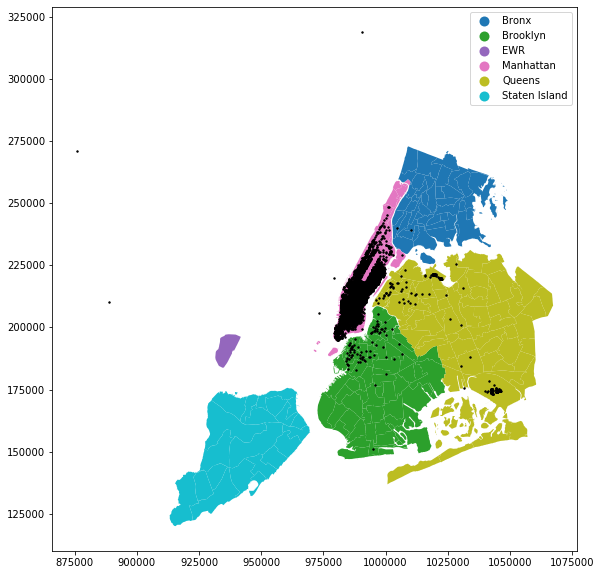

In [9]:
fig, ax = plt.subplots(figsize=(12,10))
zones.plot("borough", ax=ax, legend=True)
gdf.sample(5000).plot(ax=ax, markersize=2, color="black");

In [10]:
gdf_subset = gpd.read_file("tutorialData/taxidata.shp", mask=zones[zones["borough"].isin(["Brooklyn"])])

In [11]:
gdf.shape, gdf_subset.shape

((1458644, 12), (26395, 12))

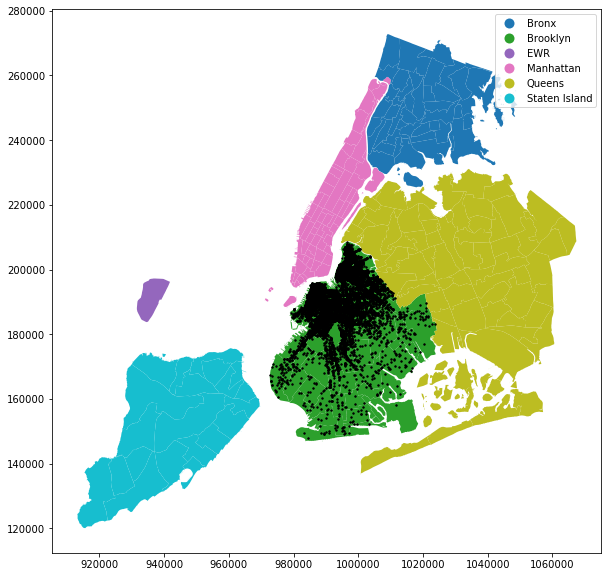

In [12]:
fig, ax = plt.subplots(figsize=(12,10))
zones.plot("borough", ax=ax, legend=True)
gdf_subset.plot(ax=ax, markersize=2, color="black");

## Spatial Index

In [13]:
boroughs = zones.dissolve(by='borough')

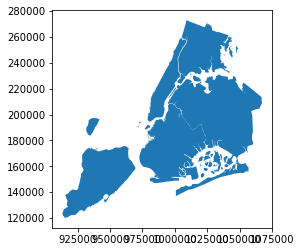

In [14]:
boroughs.plot()

In [15]:
sjoined = gpd.sjoin(gdf, boroughs, op="within")

In [16]:
gdf_sindexed = gdf
boroughs_sindexed = boroughs

In [17]:
gdf_sindexed.sindex
boroughs_sindexed.sindex

rtree.index.Index(bounds=[913175.109008804, 120121.88125434518, 1067382.508405164, 272844.2940054685], size=6)

In [18]:
sjoined = gpd.sjoin(gdf_sindexed, boroughs_sindexed, op="within")

In [19]:
sjoined.head()

id  vendor_id           pickup_dat           dropoff_da  passenger_  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30           1   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38           1   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48           1   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40           1   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10           1   

   pickup_lon  pickup_lat  dropoff_lo  dropoff_la store_and_  trip_durat  \
0  -73.982155   40.767937  -73.964630   40.765602          N         455   
1  -73.980415   40.738564  -73.999481   40.731152          N         663   
2  -73.979027   40.763939  -74.005333   40.710087          N        2124   
3  -74.010040   40.719971  -74.012268   40.706718          N         429   
4  -73.973053   40.793209  -73.972923   40.782520          N         435   

                        geometry index_right  OBJECTID  Shape_Leng  \
0  POINT (989193.143 219057.123)   Manhattan         4    0.043567   
1  POINT (989677.366 208355.623)   Manhattan         4    0.043567   
2  POINT (990059.955 217600.779)   Manhattan         4    0.043567   
3  POINT (981466.915 201581.258)   Manhattan         4    0.043567   
4  POINT (991711.507 228265.363)   Manhattan         4    0.043567   

   Shape_Area           zone  LocationID  
0    0.000112  Alphabet City           4  
1    0.000112  Alphabet City           4  
2    0.000112  Alphabet City           4  
3    0.000112  Alphabet City           4  
4    0.000112  Alphabet City           4

## 4. Plot with Datashader

In [20]:
sjoined.shape

(1457523, 18)

In [21]:
agg = ds.Canvas().points(sjoined, 'pickup_lon', 'pickup_lat')
img = tf.set_background(tf.shade(agg, cmap=fire),"black")

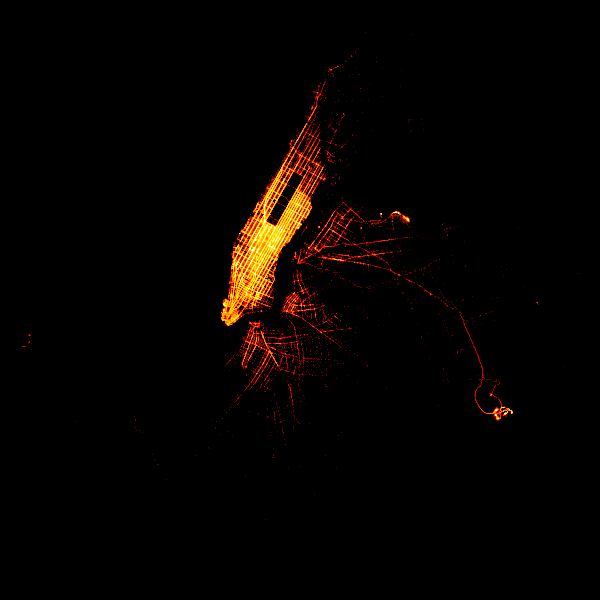

In [22]:
img

In [23]:
df = sjoined[['dropoff_lo', 'dropoff_la', 'passenger_']]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
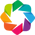

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [dropoff_lo,dropoff_la]   (R,G,B,A)

In [27]:
import holoviews as hv
from holoviews.element.tiles import EsriImagery, CartoLight, CartoDark, EsriUSATopo, StamenLabels
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

map_tiles  = StamenLabels().opts(alpha=0.5, width=900, height=480, bgcolor='black')
points     = hv.Points(df, ['dropoff_lo', 'dropoff_la'])
taxi_trips = datashade(points, x_sampling=0.0001, y_sampling=0.0001, cmap=fire, width=900, height=480)

map_tiles * taxi_trips